# Time series prediction using LSTM

## Dataset
- Daily minimum temperatures in Melbourne, Australia, 1981-1990
- Units: Degrees Celcius

## Question 1

### Load the data
- load daily-minimum-temperatures-in-me.csv

In [54]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math
from sklearn.metrics import mean_squared_error



In [13]:
data = pd.read_csv('daily-minimum-temperatures-in-me-1.csv')

### Print the data
- First 5 rows only

In [14]:
data.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Set index column
- Set the DataFrame index using "Date" column

In [15]:
data['Date']=pd.to_datetime(data['Date'],infer_datetime_format=True)
data=data.set_index(['Date'])

In [16]:
data.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


## Question 2

### Check the total count of null values in the data

In [17]:
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


In [18]:
print("Total number of null values in the dataset are:", data['Temperature'].isna().sum())

Total number of null values in the dataset are: 0


### Drop all the rows with null values
- use dropna() method

In [21]:
data.dropna(inplace=True)

## Question 3

### Describe your dataframe
- use describe() method

In [19]:
data.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


### Plot the dataframe
- use plot() method

/Users/abhinandanchiney/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


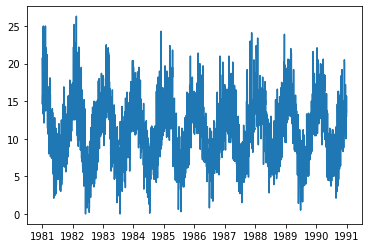

In [23]:
plt.plot(data)
plt.show()

### Get representation of the distribution of data using histogram
- use hist() method

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1233a7f50>]],
      dtype=object)

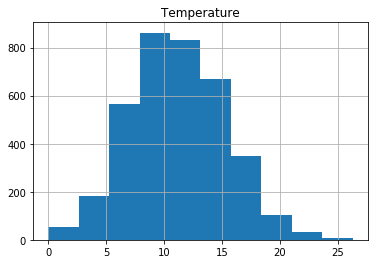

In [24]:
data.hist()

### Check minimum and maximum temperature
- use min() and max() methods

In [25]:
data.min()

Temperature    0.0
dtype: float64

In [26]:
data.max()

Temperature    26.3
dtype: float64

## Question 4

### Split the dataset into training and testing
- training data: 75%
- testing data: 25%

In [28]:
train = data[:int(len(data) * 0.75)]
test = data[int(len(data) * 0.75):len(data)]


In [29]:
len(train)

2737

In [30]:
len(test)

913

### Normalize the data
- normalize temperature values using MinMaxScaler
- feature_range: 0-1
- fit MinMaxScaler on train data and transform it
  - use fit_transform() method
- transform test data using MinMaxScaler object
  - use transform() method

In [32]:
ms = MinMaxScaler(feature_range=(0, 1))
train = ms.fit_transform(train)
test = ms.transform(test)

### Print scaled train and test data
- print only first 5 values

In [33]:
train[:5]

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       [0.55513308],
       [0.60076046]])

In [34]:
test[:5]

array([[0.22813688],
       [0.22053232],
       [0.18631179],
       [0.19011407],
       [0.31939163]])

## Question 5

### Create sequential data
Map the temperature at a particular day 'd' to the temperature at day t
'd+n', where n is any number you define.

For example: to map temperatures of consecutive days, use d+1, i.e. lookback = 1
- Below function takes data as input and returns sequential data.
- X as features and y as labels

In [35]:
import numpy as np
def create_seq_data(data, lookback=1):
  X, y = list(), list()
  
  for day in range((len(data)-lookback)):
    X.append(data[day: day+lookback, 0])
    y.append(data[day+lookback, 0])
  return np.array(X), np.array(y)

### Use the above function to create train and test sets
- Get X_train and y_train
- Get X_test and y_test
- lookback = 1

In [36]:
X_train, y_train = create_seq_data(train)
X_test, y_test = create_seq_data(test)

### Reshape the data
- Reshape X_train and X_test
- use np.reshape() method
- this is to be done to make the data ready for input in model

In [37]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Print shape of data
- print shape of X_train and X_test

In [38]:
print(X_train.shape)
print(X_test.shape)

(2736, 1, 1)
(912, 1, 1)


## Question 6

### Define sequential model
- initialize a Sequential model
- add an LSTM layer
  - units: 10
  - stateful: True
  - pass a `batch_input_shape` argument to your layer
  - batch_input_shape: (batch_size, look_back, 1)
    - batch_size: 1
    - look_back: 1
- add Dense layer with 1 neuron

In [40]:
model = Sequential()
model.add(LSTM(10, stateful=True, batch_input_shape=(1, 1, 1)))
model.add(Dense(1))

## Question 7

### compile your model
- loss: mean_squared_error
- optimizer: adam

In [41]:
model.compile(loss='mean_squared_error', optimizer='adam')

### summarize your model
- use summary() method

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 10)                   480       
_________________________________________________________________
dense (Dense)                (1, 1)                    11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Question 8

### fit your model
- epochs: 50
- batch_size: 1

In [43]:
model.fit(X_train, y_train, epochs=50, batch_size=1)

Train on 2736 samples
Epoch 1/50
2736/2736 [==============================] - 5s 2ms/sample - loss: 0.0179
Epoch 2/50
2736/2736 [==============================] - 4s 1ms/sample - loss: 0.0102
Epoch 3/50
2736/2736 [==============================] - 3s 1ms/sample - loss: 0.0102
Epoch 4/50
2736/2736 [==============================] - 4s 1ms/sample - loss: 0.0101
Epoch 5/50
2736/2736 [==============================] - 3s 1ms/sample - loss: 0.0102
Epoch 6/50
2736/2736 [==============================] - 3s 1ms/sample - loss: 0.0101
Epoch 7/50
2736/2736 [==============================] - 4s 1ms/sample - loss: 0.0101
Epoch 8/50
2736/2736 [==============================] - 4s 1ms/sample - loss: 0.0100
Epoch 9/50
2736/2736 [==============================] - 3s 1ms/sample - loss: 0.0100
Epoch 10/50
2736/2736 [==============================] - 3s 1ms/sample - loss: 0.0101
Epoch 11/50
2736/2736 [==============================] - 3s 1ms/sample - loss: 0.0101
Epoch 12/50
2736/2736 [==================

## Question 9

### make predictions on train data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [49]:
train_pred1 = model.predict(X_train, batch_size=1)

### reset model state
- if you are using stateful=True in your model then you should call reset_states every time, when you want to make consecutive model calls independent.
- use reset_states() method

In [50]:
model.reset_states()

### make predictions on test data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [51]:
test_pred2 = model.predict(X_test, batch_size=1)

## Question 10

### Inverse train predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [52]:
train_pred1 = ms.inverse_transform(train_pred1)
y_train = ms.inverse_transform([y_train])

### Inverse test predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [53]:
test_pred2 = ms.inverse_transform(test_pred2)
y_test = ms.inverse_transform([y_test])

### Evaluate train predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print training RMSE

In [55]:
train_score = math.sqrt(mean_squared_error(y_train[0], train_pred[:,0]))

In [56]:
print('Train Score: %.2f RMSE' % (train_score))

Train Score: 11.43 RMSE


### Evaluate test predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print testing RMSE

In [58]:
test_score = math.sqrt(mean_squared_error(y_test[0], test_pred2[:,0]))

In [59]:
print('Test Score: %.2f RMSE' % (test_score))

Test Score: 2.54 RMSE


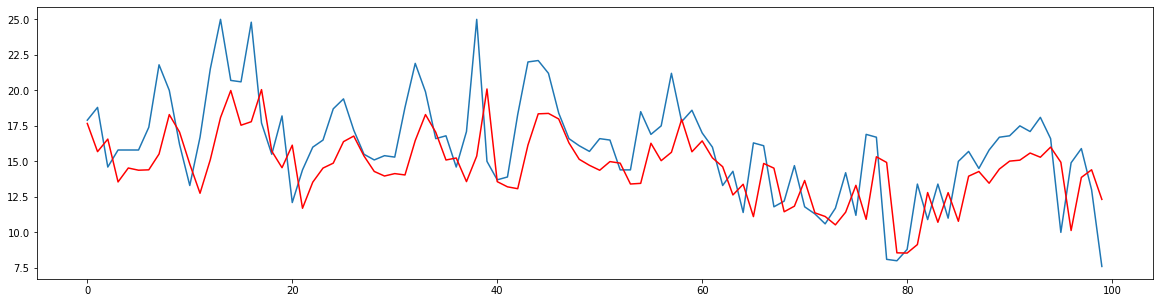

In [60]:
y_train=y_train.reshape(2736, 1)
plt.subplots(figsize=(20,5))
plt.plot(y_train[0:100])
plt.plot(train_pred1[0:100],color='red')

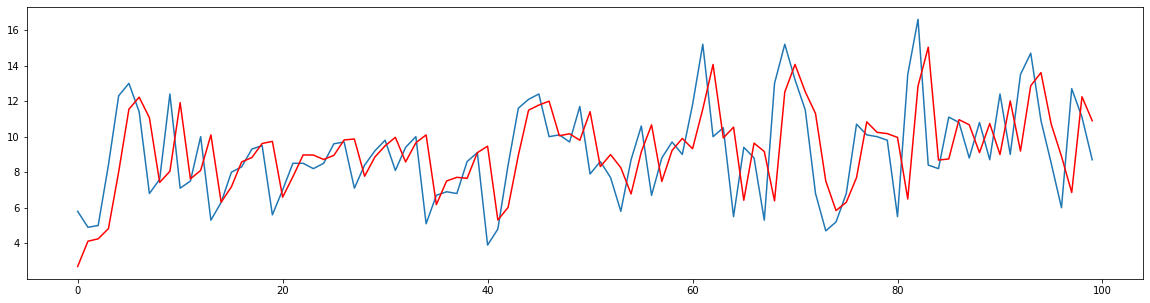

In [62]:
y_test=y_test.reshape(912, 1)
plt.subplots(figsize=(20,5))
plt.plot(y_test[0:100])
plt.plot(test_pred2[0:100],color='red')

# Neural Machine Translation

- Translate a given sentence in one language to another desired language.

#### In this notebook, we aim to build a model which can translate German sentences to English.

## Dataset

Dataset is taken from http://www.manythings.org/anki/.

We are considering German – English deu-eng.zip file from the above mentioned website.

In the above zip file there is a file with name **`deu.txt`** that contains **152,820** pairs of English to German phrases, one pair per line with a tab separating the phrases.


For example,

The first 5 lines in deu.txt are as given below.

***
```
Hi.    Hallo!
Hi.    Grüß Gott!
Run!    Lauf!
Wow!    Potzdonner!
Wow!    Donnerwetter!
```
***


## Problem

### Given a sequence of words in German as input, predict the sequence of words in English.

### 1. Prepare Data


The preprocessing of the data involves:

1. Removing punctuation marks from the data.

2. Converting text corpus into lower case characters.

3. Split into Train and Test sets.

4. Shuffling the sentences.



The above tasks are done  and full dataset is given as **``english-german-both.pkl``** respectively.

Download dataset files from here: https://drive.google.com/open?id=1gWVk7SuuE93Cf_nT9Lb7GBCiwfAgdBiX




# Character level Machine Translation

## Initialize parameters
Run the below code to initialize the variables required for the model.

In [63]:
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

### Connect to google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

### Give the path for the folder in which the dataset is present in google drive

In [67]:
pwd()

'/Users/abhinandanchiney/Desktop/AIML/res10/lab'

### Change present working directory

## Load the pickle file (`english-german-both.pkl`) into a variable with name `dataset`
Run the below code to load the .pkl file.

In [68]:
import pickle

with open('english-german-both.pkl', 'rb') as f:
  dataset = pickle.load(f)

## Check the `dataset` variable at this step. It should be as given below

In [69]:
dataset

array([['stay with us', 'bleib bei uns'],
       ['she wants him', 'sie will ihn'],
       ['youre strong', 'du bist stark'],
       ...,
       ['i thought so', 'das dachte ich mir'],
       ['keep warm', 'haltet euch warm'],
       ['im sick', 'ich bin krank']], dtype='<U291')

## Feature set and target set division from the **dataset**

### Run the below code to divide the dataset into feature set(input) and target set(output). 

1. We are creating two lists for storing input sentences and output sentences separately. 
2. We are storing each character in a list from both input and target sets separately. 
3. Print and check `input_texts` and `target_texts`.
4. Print and check `input_characters` and `target_characters`.

In [70]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for line in dataset[: min(num_samples, len(dataset) - 1)]:
    input_text, target_text = line[0], line[1]
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

### Print input text

In [71]:
print(input_texts)

['stay with us', 'she wants him', 'youre strong', 'examine this', 'heres my card', 'tom burped', 'it is no joke', 'tom is a spy', 'im a teenager', 'im not crazy', 'we cant do it', 'i like sweets', 'put it down', 'tom looks fine', 'i am hungarian', 'youre dying', 'go away', 'tom denied this', 'yes of course', 'this is ugly', 'tom cried again', 'ill prove it', 'do as he says', 'please tell me', 'he had ambition', 'look here', 'cuff him', 'is it far away', 'were cousins', 'is tom dreaming', 'i envy tom', 'find a job', 'im the expert', 'just try it', 'theyll find me', 'a car hit tom', 'have tom do it', 'close your eyes', 'come on in here', 'i like this', 'tom is history', 'try it on', 'ill sleep here', 'does that help', 'tom moved away', 'well be ok', 'im on my own', 'toms out cold', 'eat everything', 'you said it', 'he looked young', 'dont insult me', 'im upset', 'you never ask', 'i broke it', 'theyre happy', 'tom seemed sad', 'tom is a loser', 'its up to you', 'are these ours', 'tom cant

### Print target text

In [72]:
print(target_texts)

['\tbleib bei uns\n', '\tsie will ihn\n', '\tdu bist stark\n', '\tuntersuchen sie das\n', '\thier ist meine karte\n', '\ttom stie auf\n', '\tdas ist kein witz\n', '\ttom ist ein spion\n', '\tich bin ein teenager\n', '\tich bin nicht verruckt\n', '\twir konnen das nicht\n', '\tich mag sues\n', '\tlegt es hin\n', '\ttom sieht gut aus\n', '\tich bin ungarin\n', '\tdu stirbst\n', '\tverkrumele dich\n', '\ttom hat das bestritten\n', '\tja naturlich\n', '\tdas ist grauslich\n', '\ttom hat wieder geweint\n', '\tich werde es beweisen\n', '\ttu was er sagt\n', '\tbitte sagt es mir\n', '\ter war strebsam\n', '\tschau her\n', '\tlegen sie ihm handschellen an\n', '\tist es weit weg\n', '\twir sind cousins\n', '\tist tom am traumen\n', '\tich beneide tom\n', '\tsuch dir einen job\n', '\tich bin der mann vom fach\n', '\tversuchs doch einfach\n', '\tsie werden mich finden\n', '\ttom wurde von einem auto angefahren\n', '\tlass es tom machen\n', '\tmacht die augen zu\n', '\tkomm herein\n', '\tich mag d

### Print input character

In [73]:
print(input_characters)

{' ', 'e', 'y', 's', 'p', 'l', 'z', 'g', 'w', 'u', 'd', 'c', 'x', 'a', 't', 'h', 'f', 'i', 'r', 'k', 'j', 'o', 'm', 'b', 'v', 'q', 'n'}


### Print target character

In [74]:
print(target_characters)

{'\n', ' ', 'e', 'y', 's', 'p', 'l', '\t', 'z', 'g', 'w', 'u', 'd', 'c', 'x', 'a', 'h', 't', 'f', 'i', 'r', 'k', 'j', 'o', 'm', 'b', 'v', 'q', 'n'}


## Stats from the dataset

### Run the below code to check the stats from the dataset

In [75]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [76]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 9999
Number of unique input tokens: 27
Number of unique output tokens: 29
Max sequence length for inputs: 15
Max sequence length for outputs: 51



## Build character to index dictionary names `input_token_index` and `target_token_index` for input and target sets respectively.

In [79]:
input_token_index = dict([(char,i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char,i) for i, char in enumerate(target_characters)])

### Print input_index_token

In [80]:
input_token_index

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

### Print target_token_index

In [81]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

## Build Model
Initialize the required layers from keras

### Import libraries

In [82]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

### Run the below code to build one-hot vectors for the characters

In [83]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [84]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

### Build the encoder Model

Define an input sequence and process it.

Discard `encoder_outputs` and only keep the states.

In [0]:
decoder_inputs = Input(shape=(None,num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences= True, num_decoder_tokens)



### Build the decoder Model

Set up the decoder, using `encoder_states` as initial state.

We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.

### Define Model

Define the model that will turn `encoder_input_data ` & ` decoder_input_data` into `decoder_target_data`

### Compile and fit the model

### Save the model

In [0]:
# Save model
model.save('s2s.h5')

## Run the below code for inferencing the model

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

## Reverse-lookup token index to decode sequences back to something readable.

In [0]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [0]:
print(reverse_input_char_index)
print(reverse_target_char_index)

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

## Run the below code for checking some outputs from the model.

In [0]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)